# Neural Network Notebook
[Return to project overview](final_project_overview.ipynb)


### Andrew Larimer, Deepak Nagaraj, Daniel Olmstead, Michael Winton (W207-4-Summer 2018 Final Project)

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import util

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# set default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

%matplotlib inline

## Load data and split class labels into separate array

Our utility function reads the merged dataset, imputes the column mean for missing numeric values, and then performs a stratified train-test split.

In [2]:
train_data, test_data, train_labels, test_labels = util.read_data(do_imputation=True)
print(train_data.shape)
print(train_labels.shape)

Train: 371 observations (positive class fraction: 0.232)
Test : 93 observations (positive class fraction: 0.226)
(371, 75)
(371,)


> **KEY OBSERVATION**: a hypothetical model that is hard-coded to predict a `negative` result every time would be ~77% accurate.  So, we should not accept any machine-learned model with a lower accuracy than that.  This also suggests that F1 score is a better metric to assess our work since it incorporates both precision and recall.

In [3]:
train_data.info()
train_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 421 to 386
Data columns (total 75 columns):
dbn                                                 371 non-null object
school_name                                         371 non-null object
district                                            371 non-null int64
zip                                                 371 non-null int64
school_income_estimate                              104 non-null float64
grade_7_enrollment                                  371 non-null float64
num_shsat_test_takers                               371 non-null float64
offers_per_student                                  371 non-null float64
pct_test_takers                                     371 non-null float64
community_school                                    371 non-null float64
economic_need_index                                 371 non-null float64
percent_ell                                         371 non-null float64
percent_asian          

,dbn,school_name,district,zip,school_income_estimate,grade_7_enrollment,num_shsat_test_takers,offers_per_student,pct_test_takers,community_school,economic_need_index,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black__hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_students_tested,grade_7_math_4s_all_students,grade_7_math_4s_american_indian_or_alaska_native,grade_7_math_4s_black_or_african_american,grade_7_math_4s_hispanic_or_latino,grade_7_math_4s_asian_or_pacific_islander,grade_7_math_4s_white,grade_7_math_4s_multiracial,grade_7_math_4s_limited_english_proficient,grade_7_math_4s_economically_disadvantaged,sie_provided,in_bronx,in_brooklyn,in_manhattan,in_queens,in_staten,number_of_students_english,number_of_students_math,number_of_students_science,number_of_students_social_studies,number_of_classes_english,number_of_classes_math,number_of_classes_science,number_of_classes_social_studies,average_class_size_english,average_class_size_math,average_class_size_science,average_class_size_social_studies,school_pupil_teacher_ratio,gifted,selective
421,22K014,J.H.S. 014 SHELL BANK,22,11235,NaN,168.0,41.0,0.0,19.0,0.0,0.708,18.0,11.0,48.0,17.0,64.0,24.0,92.0,29.0,86.0,3.0,91.0,3.0,80.0,3.0,86.0,3.0,71.0,2.0,92.0,3.0,3.0,2.32,2.41,165.0,8.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,7.0,178.0,14.0,0.0,2.0,2.0,0.0,6.0,0.0,1.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,767.0,606.0,765.0,622.000000,37.0,29.0,36.0,28.000000,20.729730,20.896552,21.250000,22.214286,12.5,0.0,0.0
344,32K554,ALL CITY LEADERSHIP SECONDARY SCHOOL,32,11237,NaN,61.0,22.0,0.0,17.0,0.0,0.667,2.0,6.0,11.0,77.0,89.0,5.0,97.0,8.0,92.0,4.0,99.0,4.0,96.0,4.0,92.0,4.0,83.0,3.0,98.0,4.0,3.0,3.28,3.47,60.0,22.0,0.0,2.0,18.0,0.0,0.0,0.0,0.0,20.0,60.0,19.0,0.0,2.0,15.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,330.0,180.0,180.0,180.000000,13.0,6.0,6.0,6.000000,25.384615,30.000000,30.000000,30.000000,23.9,0.0,0.0
279,19K654,VAN SICLEN COMMUNITY MIDDLE SCHOOL,19,11207,NaN,106.0,15.0,0.0,16.0,0.0,0.780,14.0,2.0,68.0,28.0,96.0,2.0,90.0,33.0,86.0,3.0,96.0,3.0,83.0,3.0,93.0,4.0,80.0,3.0,95.0,4.0,2.0,1.96,1.95,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,312.0,327.0,327.0,297.000000,14.0,14.0,12.0,12.000000,22.285714,23.357143,27.250000,24.750000,16.7,0.0,0.0
244,17K394,M.S. K394,17,11213,32470.47,49.0,12.0,0.0,21.0,0.0,0.797,4.0,6.0,77.0,15.0,92.0,1.0,92.0,24.0,89.0,3.0,86.0,3.0,83.0,2.0,80.0,3.0,82.0,2.0,85.0,2.0,2.0,2.35,2.21,57.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,284.0,308.0,154.0,154.000000,13.0,14.0,7.0,7.000000,21.846154,22.000000,22.000000,22.000000,14.0,0.0,0.0
379,08X562,BLUEPRINT MIDDLE SCHOOL,8,10472,NaN,120.0,29.0,0.0,30.0,0.0,0.796,15.0,23.0,18.0,56.0,74.0,1.0,92.0,29.0,93.0,3.0,95.0,3.0,80.0,2.0,93.0,4.0,79.0,3.0,91.0,3.0,2.0,2.23,2.17,102.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,49.0,331.0,383.0,425.537079,2.0,14.0,16.0,17.116854,24.500000,23.642857,23.937500,24.057379,13.3,0.0,0.0
347,19K218,J.H.S. 218 JAMES P. SINNOTT,19,11208,NaN,146.0,23.0,0.0,16.0,0.0,0.857,2

> **KEY OBSERVATION**: the feature `school_income_estimate` only has non-null values for 104 of 371 records in the training data.  We should drop it from further analysis, as imputing its value for the non-null records isn't appropriate.

## Create a function to estimate MLP models and report results
We create a pipeline that will be used for k-fold cross-validation.  First, we scale the features, then perform dimensionality reduction by PCA if requested by the caller, then estimate a multilayer perceptron neural network with the hidden layers defined by the caller. Once the pipeline is built, we perform cross-validation, print the results, and return key statistics.

In [4]:
def estimate_mlp(train_data, train_labels, n_pca=None,
                 hidden_layers=None, k_folds=5, max_iter=1000, print_results=True):

    # if tuple describing hidden layer nodes isn't provided, set default
    if not hidden_layers:
        n_features = train_data.shape[1]
        hidden_layers = (n_features,n_features,n_features)
        
    # build pipelines, with or without PCA as appropriate
    if n_pca:
        # create a pipeline to run StandardScaler and MLP
        print('Estimating pipeline with PCA; hidden layers:',hidden_layers)
        pipeline = make_pipeline(StandardScaler(with_mean=False), 
                                 PCA(n_components=n_pca, random_state=207),
                                 MLPClassifier(hidden_layer_sizes=hidden_layers,
                                               max_iter=max_iter, random_state=207))
    else:
        # create a pipeline to run StandardScaler and MLP
        print('Estimating pipeline without PCA; hidden layers:',hidden_layers)
        pipeline = make_pipeline(StandardScaler(with_mean=False), 
                                 MLPClassifier(hidden_layer_sizes=hidden_layers,
                                               max_iter=max_iter, random_state=207))

    # Do k-fold cross-validation, collecting both "test" accuracy and F1 
    cv_scores = cross_validate(pipeline, train_data, train_labels, cv=k_folds, scoring=['accuracy','f1'])
    if print_results:
        util.print_cv_results(cv_scores)
        
    # extract and return accuracy, F1
    cv_accuracy = cv_scores['test_accuracy']
    cv_f1 = cv_scores['test_f1']
    return (cv_accuracy.mean(), cv_accuracy.std(), cv_f1.mean(), cv_f1.std())


## Train and fit a "naive" model
For the first model, we'll use all features except SHSAT-related features because they are too correlated with the way we calculated the label.  We'll also drop `school_income_estimate` because it's missing for ~2/3 of the schools.  We drop zip code (too granular to have many schools per zip) in favor of the indicator variables `in_[borough]`.

In [5]:
drop_cols = ['dbn',
             'num_shsat_test_takers',
             'offers_per_student',
             'pct_test_takers',
             'school_name',
             'school_income_estimate',
             'zip'
            ]

# drop SHSAT-related columns
train_data_naive = train_data.drop(drop_cols, axis=1)
test_data_naive = test_data.drop(drop_cols, axis=1)

print(train_data_naive.shape)
train_data_naive.head()

(371, 68)


,district,grade_7_enrollment,community_school,economic_need_index,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black__hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_students_tested,grade_7_math_4s_all_students,grade_7_math_4s_american_indian_or_alaska_native,grade_7_math_4s_black_or_african_american,grade_7_math_4s_hispanic_or_latino,grade_7_math_4s_asian_or_pacific_islander,grade_7_math_4s_white,grade_7_math_4s_multiracial,grade_7_math_4s_limited_english_proficient,grade_7_math_4s_economically_disadvantaged,sie_provided,in_bronx,in_brooklyn,in_manhattan,in_queens,in_staten,number_of_students_english,number_of_students_math,number_of_students_science,number_of_students_social_studies,number_of_classes_english,number_of_classes_math,number_of_classes_science,number_of_classes_social_studies,average_class_size_english,average_class_size_math,average_class_size_science,average_class_size_social_studies,school_pupil_teacher_ratio,gifted,selective
421,22,168.0,0.0,0.708,18.0,11.0,48.0,17.0,64.0,24.0,92.0,29.0,86.0,3.0,91.0,3.0,80.0,3.0,86.0,3.0,71.0,2.0,92.0,3.0,3.0,2.32,2.41,165.0,8.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,7.0,178.0,14.0,0.0,2.0,2.0,0.0,6.0,0.0,1.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,767.0,606.0,765.0,622.000000,37.0,29.0,36.0,28.000000,20.729730,20.896552,21.2500,22.214286,12.5,0.0,0.0
344,32,61.0,0.0,0.667,2.0,6.0,11.0,77.0,89.0,5.0,97.0,8.0,92.0,4.0,99.0,4.0,96.0,4.0,92.0,4.0,83.0,3.0,98.0,4.0,3.0,3.28,3.47,60.0,22.0,0.0,2.0,18.0,0.0,0.0,0.0,0.0,20.0,60.0,19.0,0.0,2.0,15.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,330.0,180.0,180.0,180.000000,13.0,6.0,6.0,6.000000,25.384615,30.000000,30.0000,30.000000,23.9,0.0,0.0
279,19,106.0,0.0,0.780,14.0,2.0,68.0,28.0,96.0,2.0,90.0,33.0,86.0,3.0,96.0,3.0,83.0,3.0,93.0,4.0,80.0,3.0,95.0,4.0,2.0,1.96,1.95,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,312.0,327.0,327.0,297.000000,14.0,14.0,12.0,12.000000,22.285714,23.357143,27.2500,24.750000,16.7,0.0,0.0
244,17,49.0,0.0,0.797,4.0,6.0,77.0,15.0,92.0,1.0,92.0,24.0,89.0,3.0,86.0,3.0,83.0,2.0,80.0,3.0,82.0,2.0,85.0,2.0,2.0,2.35,2.21,57.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,284.0,308.0,154.0,154.000000,13.0,14.0,7.0,7.000000,21.846154,22.000000,22.0000,22.000000,14.0,0.0,0.0
379,8,120.0,0.0,0.796,15.0,23.0,18.0,56.0,74.0,1.0,92.0,29.0,93.0,3.0,95.0,3.0,80.0,2.0,93.0,4.0,79.0,3.0,91.0,3.0,2.0,2.23,2.17,102.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,49.0,331.0,383.0,425.537079,2.0,14.0,16.0,17.116854,24.500000,23.642857,23.9375,24.057379,13.3,0.0,0.0


## One hot encode the categorical explanatory variables
Columns such as zip code and school district ID, which are integers, should not be fed into an ML model as integers.  Instead, we need to treat them as factors and perform one-hot encoding.  Since we have already removed zip code from our dataframe (in favor of boroughs), we only need to one hot encode `district`.

In [6]:
train_data_naive_ohe, test_data_naive_ohe = util.get_dummies(train_data_naive, test_data_naive,
                                                             factor_cols=['district'])
train_data_naive_ohe.head()

Train data initial shape: (371, 68)
Test  data initial shape: (93, 68)
Train data OHE'd shape: (371, 99)
Test  data OHE'd shape: (93, 99)


,grade_7_enrollment,community_school,economic_need_index,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black__hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_students_tested,grade_7_math_4s_all_students,grade_7_math_4s_american_indian_or_alaska_native,grade_7_math_4s_black_or_african_american,grade_7_math_4s_hispanic_or_latino,grade_7_math_4s_asian_or_pacific_islander,grade_7_math_4s_white,grade_7_math_4s_multiracial,grade_7_math_4s_limited_english_proficient,grade_7_math_4s_economically_disadvantaged,sie_provided,in_bronx,in_brooklyn,in_manhattan,in_queens,in_staten,number_of_students_english,number_of_students_math,number_of_students_science,number_of_students_social_studies,number_of_classes_english,number_of_classes_math,number_of_classes_science,number_of_classes_social_studies,average_class_size_english,average_class_size_math,average_class_size_science,average_class_size_social_studies,school_pupil_teacher_ratio,gifted,selective,district_1,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9,district_10,district_11,district_12,district_13,district_14,district_15,district_16,district_17,district_18,district_19,district_20,district_21,district_22,district_23,district_24,district_25,district_26,district_27,district_28,district_29,district_30,district_31,district_32
421,168.0,0.0,0.708,18.0,11.0,48.0,17.0,64.0,24.0,92.0,29.0,86.0,3.0,91.0,3.0,80.0,3.0,86.0,3.0,71.0,2.0,92.0,3.0,3.0,2.32,2.41,165.0,8.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,7.0,178.0,14.0,0.0,2.0,2.0,0.0,6.0,0.0,1.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,767.0,606.0,765.0,622.000000,37.0,29.0,36.0,28.000000,20.729730,20.896552,21.2500,22.214286,12.5,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
344,61.0,0.0,0.667,2.0,6.0,11.0,77.0,89.0,5.0,97.0,8.0,92.0,4.0,99.0,4.0,96.0,4.0,92.0,4.0,83.0,3.0,98.0,4.0,3.0,3.28,3.47,60.0,22.0,0.0,2.0,18.0,0.0,0.0,0.0,0.0,20.0,60.0,19.0,0.0,2.0,15.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,330.0,180.0,180.0,180.000000,13.0,6.0,6.0,6.000000,25.384615,30.000000,30.0000,30.000000,23.9,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279,106.0,0.0,0.780,14.0,2.0,68.0,28.0,96.0,2.0,90.0,33.0,86.0,3.0,96.0,3.0,83.0,3.0,93.0,4.0,80.0,3.0,95.0,4.0,2.0,1.96,1.95,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,312.0,327.0,327.0,297.000000,14.0,14.0,12.0,12.000000,22.285714,23.357143,27.2500,24.750000,16.7,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
244,49.0,0.0,0.797,4.0,6.0,77.0,15.0,92.0,1.0,92.0,24.0,89.0,3.0,86.0,3.0,83.0,2.0,80.0,3.0,82.0,2.0,85.0,2.0,2.0,2.35,2.21,57.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,284.0,308.0,154.0,154.000000,13.0,14.0,7.0,7.000000,21.846154,22.000000,22.0000,22.000000,14.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
379,120.0,0.0,0.796,15.0,23.0,18.0,56.0,74.0,1.0,92.0,29.0,93.0,3.0,95.0,3.0,80.0,2.0,93.0,4.0,79.0,3.0,91.0,3.0,2.0,2.23,2.17,102.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,

## Estimate the "naive" multilayer perceptron model
This first "naive" model uses all except for the SHSAT-related features, as described above.  

In [7]:
# discard return vals; only print results
(_,_,_,_) = estimate_mlp(train_data_naive_ohe, train_labels, k_folds=5, max_iter=1000)

Estimating pipeline without PCA; hidden layers: (99, 99, 99)
With 5-fold cross-validation, accuracy is: 0.827 (95% CI from 0.727 to 0.928).
The F1 score is: 0.633 (95% CI from 0.382 to 0.884).


## Train a "naive" model without location (zip, borough, or district)
Next, we remove all location features (zip, borough, and district) to compare accuracy to the prior model.

In [8]:
drop_cols = ['dbn',
             'num_shsat_test_takers',
             'offers_per_student',
             'pct_test_takers',
             'school_name',
             'school_income_estimate',
             'district',
             'zip',
             'in_bronx',
             'in_brooklyn',
             'in_manhattan',
             'in_queens',
             'in_staten'
            ]

# drop SHSAT-related columns + district, zip, borough
train_data_naive_nozip = train_data.drop(drop_cols, axis=1)
test_data_naive_nozip = test_data.drop(drop_cols, axis=1)

print(train_data_naive_nozip.shape)
print(train_labels.shape)

(371, 62)
(371,)


## Estimate the "naive" multilayer perceptron model without location


In [9]:
# discard return vals; only print results
(_,_,_,_) = estimate_mlp(train_data_naive_nozip, train_labels, k_folds=5, max_iter=1000)

Estimating pipeline without PCA; hidden layers: (62, 62, 62)
With 5-fold cross-validation, accuracy is: 0.825 (95% CI from 0.728 to 0.922).
The F1 score is: 0.600 (95% CI from 0.365 to 0.835).


While the accuracy is similar to the first model, the F1 score is lower.  This suggests that it's important to keep location-oriented factors in the model. 

## Train a "race-blind" multilayer perceptron model
Because we know there's an existing bias problem in the NYC schools, in that the demographics of the test taking population have been getting more homogenous, and the explicit goal of PASSNYC is to make the pool more diverse, we want to train a model that excludes most demographic features.  This would enable us to train a "race-blind" model.  

### Preprocess new X_train and X_test datasets
We will remove all explicitly demographic columns, as well as economic factors, borough, and zip code, which are likely highly correlated with demographics.

In [10]:
# drop SHSAT-related columns
drop_cols = ['dbn',
             'num_shsat_test_takers',
             'offers_per_student',
             'pct_test_takers',
             'school_name',
             'school_income_estimate'
            ]
train_data_race_blind = train_data.drop(drop_cols, axis=1)
test_data_race_blind = test_data.drop(drop_cols, axis=1)

# drop additional (demographic) columns
race_cols = ['percent_ell',
             'percent_asian',
             'percent_black',
             'percent_hispanic',
             'percent_black__hispanic',
             'percent_white',
             'economic_need_index',
             'zip',
             'in_bronx',
             'in_brooklyn',
             'in_manhattan',
             'in_queens',
             'in_staten'
             ]
train_data_race_blind = train_data_race_blind.drop(race_cols, axis=1)
test_data_race_blind = test_data_race_blind.drop(race_cols, axis=1)

# one-hot encode these features as factors
factor_cols = ['district']
train_data_race_blind_ohe, test_data_race_blind_ohe =util.get_dummies(train_data_race_blind,
                                                                      test_data_race_blind, factor_cols)

Train data initial shape: (371, 56)
Test  data initial shape: (93, 56)
Train data OHE'd shape: (371, 87)
Test  data OHE'd shape: (93, 87)


## Estimate the "race blind" multilayer perceptron model


In [11]:
# discard return vals; only print results
(_,_,_,_) = estimate_mlp(train_data_race_blind_ohe, train_labels, k_folds=5, max_iter=1000)

Estimating pipeline without PCA; hidden layers: (87, 87, 87)
With 5-fold cross-validation, accuracy is: 0.811 (95% CI from 0.715 to 0.907).
The F1 score is: 0.578 (95% CI from 0.357 to 0.799).


The F1 score for the race-blind model declines further when we remove these features.  Of the models we have tested, the original "naive" model (with the most features) performs better than our race-blind model, or our model that excluded only zip and district.

## Experiment with dimensionality reduction via PCA
Since manual feature selection performed poorly, it doesn't seem to be a promising approach.  Instead, we will experiment with Principal Component Analysis for dimensionality reduction, starting with the "naive" set of columns.

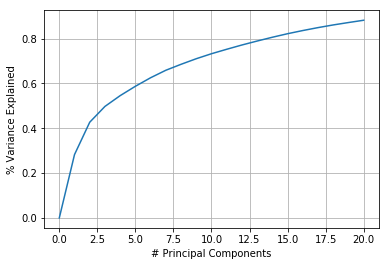

In [12]:
# Determine the number of principal components to achieve 90% explained variance
n_pca = util.get_num_pcas(train_data_naive, var_explained=0.9)


In [13]:
print('Using %d principal components' % (n_pca)) # currently n_pca=69

# discard return vals; only print results
(_,_,_,_) = estimate_mlp(train_data_naive_ohe, train_labels, n_pca=n_pca, k_folds=5, max_iter=1000)

Using 68 principal components
Estimating pipeline with PCA; hidden layers: (99, 99, 99)
With 5-fold cross-validation, accuracy is: 0.819 (95% CI from 0.678 to 0.960).
The F1 score is: 0.581 (95% CI from 0.234 to 0.929).


Applying PCA for dimensionality reduction, in contrast to manual feature selection, seemed to improve our results.  

## Use grid search to identify best set of hidden layer parameters
Since the usage of PCA seemed to improve our F1 score (and tighten its confidence interval), we will proceed to optimize the hidden layer parameters while using PCA and the original "naive" feature set.

In [14]:
# Running grid search for different combinations of neural network parameters is slow.
# If results already exist as a file, load them instead of re-running.
try:
    grid_search_results = pd.read_csv('cache_neuralnet/gridsearch_results.csv')
    print('Loaded grid search results from file.')
except FileNotFoundError:
    print('Performing grid search for best hidden layer parameters.')

    # We'll time it and report how long it took to run:
    start_time = time.time()

    # numbers of hidden nodes = these multipliers * # features
    n_features = train_data_naive_ohe.shape[1]
#     fraction = [0.25, 0.5]
    fraction = [0.25, 0.5, 1.0, 1.5, 2.0]
    n_layer_features = (int(f * n_features) for f in fraction)
    n_nodes = list(n_layer_features)

    # create list of tuples of hidden layer param permutations
    # only explore up to 4 hidden layers
    hl_param_candidates = []
    for h1 in n_nodes:
        hl_param_candidates.append((h1))
        for h2 in n_nodes:
            hl_param_candidates.append((h1,h2))
            for h3 in n_nodes:
                hl_param_candidates.append((h1,h2,h3))
                for h4 in n_nodes:
                    hl_param_candidates.append((h1,h2,h3,h4))
    
    # train an MLP model and perform cross-validation for each parameter set
    print('Estimating %d MLP models. This will take time!\n' % (len(hl_param_candidates)))
    tmp_results = []        
    for hl in hl_param_candidates:
        tmp_acc, tmp_acc_std, tmp_f1, tmp_f1_std = estimate_mlp(train_data_naive_ohe, train_labels, 
                                                                hidden_layers=hl, n_pca=n_pca,
                                                                k_folds=5, max_iter=1000, print_results=False)
        tmp_results.append((hl, tmp_acc, tmp_acc - 1.96 * tmp_acc_std, tmp_acc + 1.96 * tmp_acc_std,
                                    tmp_f1, tmp_f1 - 1.96 * tmp_f1_std, tmp_f1 + 1.96 * tmp_f1_std))

    # calculated elapsed time
    end_time = time.time()
    took = int(end_time - start_time)
    print("Grid search took {0:d} minutes, {1:d} seconds.".format(took // 60, took % 60))

    # convert results to a dataframe for easier display
    grid_search_results = pd.DataFrame(tmp_results)
    grid_search_results.columns=(['Hidden Layers','Accuracy','Acc Lower CI', 'Acc Upper CI','F1','F1 Lower CI','F1 Upper CI'])
    grid_search_results.to_csv('cache_neuralnet/gridsearch_results.csv', index=False)

# Display grid search results
grid_search_results.sort_values(by='F1', ascending=False)

Loaded grid search results from file.


,Hidden Layers,Accuracy,Acc Lower CI,Acc Upper CI,F1,F1 Lower CI,F1 Upper CI
620,"(148, 198, 198, 49)",0.862378,0.769504,0.955253,0.674877,0.421821,0.927932
487,"(148, 24, 99, 198)",0.846198,0.744283,0.948113,0.655521,0.424622,0.886419
481,"(148, 24, 49, 198)",0.851604,0.732707,0.970500,0.654368,0.357220,0.951516
471,"(148, 24, 24, 24)",0.848901,0.736784,0.961018,0.653513,0.391342,0.915684
167,"(49, 24, 49, 99)",0.840757,0.704804,0.976709,0.652745,0.364710,0.940781
745,"(198, 148, 198, 49)",0.848865,0.757391,0.940339,0.651367,0.416111,0.886623
292,"(49, 198, 49, 148)",0.838090,0.714457,0.961723,0.649159,0.406060,0.892257
488,"(148, 24, 148)",0.851568,0.736234,0.966901,0.646225,0.357867,0.934584
311,"(49, 198, 198, 198)",0.835387,0.717068,0.953707,0.645537,0.385787,0.905286
661,"(198, 49, 24, 148)",0.851568,0.767138,0.935997,0.644802,0.405189,0.884414


In [15]:
# put best grid search params into a varaiable
best_param_idx = grid_search_results['F1'].idxmax()

try:  # this is needed when loading from file
    best_hl_params = eval(grid_search_results['Hidden Layers'][best_param_idx])
except TypeError:  # eval isn't needed when results are still in memory
    best_hl_params = grid_search_results['Hidden Layers'][best_param_idx]
    
best_hl_params

(148, 198, 198, 49)

## Calculate "out-of-sample" test set accuracy
At this point we can use our "best" model parameters to classify our test set, and compare to true labels.

> NOTE: This code was left commented out until after hyperparameter optimization was complete.  

In [16]:
# set up pipeline with optimal parameters
pipeline = make_pipeline(StandardScaler(with_mean=False), 
                     PCA(n_components=n_pca, random_state=207),
                     MLPClassifier(hidden_layer_sizes=best_hl_params,
                                   max_iter=1000, random_state=207))
pipeline.fit(train_data_naive_ohe, train_labels)
test_predict = pipeline.predict(test_data_naive_ohe)

print('Test set accuracy: %.2f\n' % (np.mean(test_predict==test_labels)))
print('Confusion matrix:')
cm = confusion_matrix(test_labels, test_predict)
print(cm)
tn, fp, fn, tp = cm.ravel()
print('True negatives: %d' % (tn))
print('True positives: %d' % (tp))
print('False negatives: %d' % (fn))
print('False positives: %d\n' % (fp))
print(classification_report(test_labels, test_predict))

Test set accuracy: 0.81

Confusion matrix:
[[65  7]
 [11 10]]
True negatives: 65
True positives: 10
False negatives: 11
False positives: 7

             precision    recall  f1-score   support

        0.0       0.86      0.90      0.88        72
        1.0       0.59      0.48      0.53        21

avg / total       0.79      0.81      0.80        93



## Prioritized Engagement recommendations

Lastly, according to the methodology described in our [overview notebook](final_project_overview.ipynb), we will make our recommendations to PASSNYC based on an analysis of schools that the models show to have the highest opportunity to engage with Black and Hispanic students, in order to increase SHSAT registration in this population. We consider these to be the schools that are most likely to benefit from PASSNYC's intervention and engagement.

In [17]:
# build a pipeline with the best parameters
pipeline = make_pipeline(StandardScaler(with_mean=False), 
                         PCA(n_components=n_pca, random_state=207),
                         MLPClassifier(hidden_layer_sizes=best_hl_params,
                                       max_iter=1000, random_state=207))

# Let us look at what schools the model classified as positive, but were actually negative.  
# These are the schools we should target, because the model thinks they should have high SHSAT registrations,
# but in reality they do not.
# call our utility function to get predictions for all observations (train and test)
print('Be patient...')
predictions = util.run_model_get_ordered_predictions(pipeline, train_data, test_data,
                                                     train_data_naive_ohe, test_data_naive_ohe,
                                                     train_labels, test_labels)

# from these results, calculate a ranking of the schools that we can provide to PASSNYC.
df_passnyc = util.create_passnyc_list(predictions, train_data, test_data, train_labels, test_labels)

# Write to CSV
df_passnyc.to_csv('results/results.neuralnet.csv')

# Display results
df_passnyc.head()

Be patient...


,rank,1s,dbn,school_name,economic_need_index,grade_7_enrollment,num_shsat_test_takers,pct_test_takers,percent_black__hispanic,minority_delta,score
460,1,7.0,20K062,J.H.S. 062 DITMAS,0.741,434.0,104.0,26.0,55.0,65,45.5
459,2,9.0,17K061,M.S. 061 DR. GLADSTONE H. ATWELL,0.713,279.0,96.0,35.0,94.0,44,39.6
45,3,10.0,30Q230,I.S. 230,0.601,439.0,157.0,36.0,57.0,38,38.0
40,4,10.0,20K220,J.H.S. 220 JOHN J. PERSHING,0.828,473.0,181.0,34.0,45.0,27,27.0
31,5,10.0,24Q005,I.S. 5 - THE WALTER CROWLEY INTERMEDIATE SCHOOL,0.643,614.0,264.0,41.0,54.0,27,27.0


## Post-hoc comparison of prioritization score vs. economic need index
Even though economic need index was not an explicit factor in our post-classification prioritization scoring/ranking system, it is interesting to observe that there is some correlation:

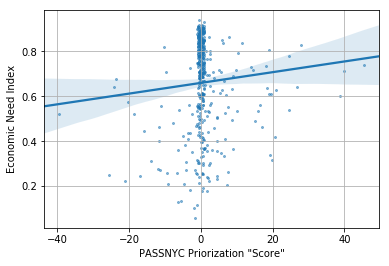

In [19]:
x = df_passnyc['score']
y = df_passnyc['economic_need_index']
sns.regplot(x='score', y='economic_need_index', data=df_passnyc,
           fit_reg=True, x_jitter=1, scatter_kws={'alpha': 0.5, 's':4})
# plt.scatter(x, y)
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('PASSNYC Priorization "Score"')
plt.ylabel('Economic Need Index')
plt.grid()
plt.show()
